# Programming Practice: Learning Classification with PySpark

---

In this pratice, we will explore how to use PySpark to perform random forest classification, evaluation and hyperparameter tuning. The goal of this practice for you is to learn about the PySpark library package and how to translate your existing knowledge of machine learning into this large-scale data processing framework.

## Setup

In order to work with the Spark context, we need to first create a Spark Session. To do so, we can run the code below.

In [1]:
import pyspark
from pyspark.sql import SparkSession, Row

import os

conf = pyspark.SparkConf().setAll([('spark.master', 'local[*]'),
                                   ('spark.app.name', 'Weather Cluster Analysis')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version, pyspark.version.__version__)

2.4.5 2.4.5


We will also import some previous libraries to assist our visualization and data manipulation work 

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np0

## Exploratory Data Analysis with Spark

In this section, we will perform basic data manipulation task with Spark

1) Here we want to load the **loan.csv** dataset into the spark context and assign the new DataFrame as **df**.

In [4]:
data_path = 'loans.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True).cache()

2) Print out all the columns with the datatype 'int' from the DataFrame

In [5]:
df.dtypes

columnlist = [item[0] for item in df.dtypes if item[1].startswith('int')]
print(columnlist)

['bc_open_to_buy', 'loan_amnt', 'max_bal_bc', 'total_bc_limit', 'total_rev_hi_lim', 'emp_length_int', 'grade_label', 'application_type_Joint App', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'term_ 60 months', 'title_Car financing', 'title_Credit card refinancing', 'title_Debt consolidation', 'title_Green loan', 'title_Home buying', 'title_Home improvement', 'title_Major purchase', 'title_Medical expenses', 'title_Moving and relocation', 'title_Other', 'title_Vacation', 'verification_status_Source Verified', 'verification_status_Verified']


3) Display the top 5 rows of the DataFrame

In [6]:
df.show(5)

+----------+--------------+-------+--------+---------+----------+----------------+--------------+-------------+----------------+--------------+-----------+--------------------------+-----------------------+------------------+-------------------+---------------+-------------------+-----------------------------+------------------------+----------------+-----------------+----------------------+--------------------+----------------------+---------------------------+-----------+--------------+-----------------------------------+----------------------------+
|annual_inc|bc_open_to_buy|bc_util|int_rate|loan_amnt|max_bal_bc|percent_bc_gt_75|total_bc_limit|total_rec_int|total_rev_hi_lim|emp_length_int|grade_label|application_type_Joint App|home_ownership_MORTGAGE|home_ownership_OWN|home_ownership_RENT|term_ 60 months|title_Car financing|title_Credit card refinancing|title_Debt consolidation|title_Green loan|title_Home buying|title_Home improvement|title_Major purchase|title_Medical expenses|tit

4) Find all the column names inside the DataFrame except "grade_label" and "int_rate". Store these column names in a list called **feature_cols** and print the list out. 

In [7]:
feature_cols = [c for c in df.schema.names if c not in {'grade_label','int_rate'}]
print(feature_cols)

['annual_inc', 'bc_open_to_buy', 'bc_util', 'loan_amnt', 'max_bal_bc', 'percent_bc_gt_75', 'total_bc_limit', 'total_rec_int', 'total_rev_hi_lim', 'emp_length_int', 'application_type_Joint App', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'term_ 60 months', 'title_Car financing', 'title_Credit card refinancing', 'title_Debt consolidation', 'title_Green loan', 'title_Home buying', 'title_Home improvement', 'title_Major purchase', 'title_Medical expenses', 'title_Moving and relocation', 'title_Other', 'title_Vacation', 'verification_status_Source Verified', 'verification_status_Verified']


5) Use **feature_cols** to only display the selected columns from the DataFrame. Print out only the first 5 rows of it.

In [9]:
df.select(feature_cols).show(5)

+----------+--------------+-------+---------+----------+----------------+--------------+-------------+----------------+--------------+--------------------------+-----------------------+------------------+-------------------+---------------+-------------------+-----------------------------+------------------------+----------------+-----------------+----------------------+--------------------+----------------------+---------------------------+-----------+--------------+-----------------------------------+----------------------------+
|annual_inc|bc_open_to_buy|bc_util|loan_amnt|max_bal_bc|percent_bc_gt_75|total_bc_limit|total_rec_int|total_rev_hi_lim|emp_length_int|application_type_Joint App|home_ownership_MORTGAGE|home_ownership_OWN|home_ownership_RENT|term_ 60 months|title_Car financing|title_Credit card refinancing|title_Debt consolidation|title_Green loan|title_Home buying|title_Home improvement|title_Major purchase|title_Medical expenses|title_Moving and relocation|title_Other|title

6) Print out all the unique values stored in "grade_label" and for each unique value, print out its total number of samples.

In [10]:
df.select("grade_label").distinct().show()

df.groupBy('grade_label').count().show()

+-----------+
|grade_label|
+-----------+
|          1|
|          3|
|          2|
+-----------+

+-----------+-----+
|grade_label|count|
+-----------+-----+
|          1|11040|
|          3|10361|
|          2|11932|
+-----------+-----+



7) Print out the first 5 rows where the "grade_label" is 1

In [11]:
df.filter(df.grade_label == "1").show(5)

+----------+--------------+-------+--------+---------+----------+----------------+--------------+-------------+----------------+--------------+-----------+--------------------------+-----------------------+------------------+-------------------+---------------+-------------------+-----------------------------+------------------------+----------------+-----------------+----------------------+--------------------+----------------------+---------------------------+-----------+--------------+-----------------------------------+----------------------------+
|annual_inc|bc_open_to_buy|bc_util|int_rate|loan_amnt|max_bal_bc|percent_bc_gt_75|total_bc_limit|total_rec_int|total_rev_hi_lim|emp_length_int|grade_label|application_type_Joint App|home_ownership_MORTGAGE|home_ownership_OWN|home_ownership_RENT|term_ 60 months|title_Car financing|title_Credit card refinancing|title_Debt consolidation|title_Green loan|title_Home buying|title_Home improvement|title_Major purchase|title_Medical expenses|tit

## Data Preprocessing with Spark

To perform the random forest analysis on this dataset, we need to prepare/encode our feature columns in addition to the label column. Here, you are asked to perform data preprocessing using only the spark library functions.

8) Take all the columns in **feature_cols** and concatenate their value into a vector format and create a new vector column named "featuresRandomForest" inside the DataFrame. Here, you want to use **VectorAssembler** from **pyspark.ml.feature** package to create such new column in the DataFrame.

In [12]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol='featuresRandomForest')
featuresDF = assembler.transform(df)
featuresDF.show(1)

+----------+--------------+-------+--------+---------+----------+----------------+--------------+-------------+----------------+--------------+-----------+--------------------------+-----------------------+------------------+-------------------+---------------+-------------------+-----------------------------+------------------------+----------------+-----------------+----------------------+--------------------+----------------------+---------------------------+-----------+--------------+-----------------------------------+----------------------------+--------------------+
|annual_inc|bc_open_to_buy|bc_util|int_rate|loan_amnt|max_bal_bc|percent_bc_gt_75|total_bc_limit|total_rec_int|total_rev_hi_lim|emp_length_int|grade_label|application_type_Joint App|home_ownership_MORTGAGE|home_ownership_OWN|home_ownership_RENT|term_ 60 months|title_Car financing|title_Credit card refinancing|title_Debt consolidation|title_Green loan|title_Home buying|title_Home improvement|title_Major purchase|title

9)  Make a duplicate column of "grade_label" and name the new column as "labelRandomForest" 

In [13]:
featuresDF_1=featuresDF.withColumn("labelRandomForest", featuresDF["grade_label"])
featuresDF_1.show(1)

+----------+--------------+-------+--------+---------+----------+----------------+--------------+-------------+----------------+--------------+-----------+--------------------------+-----------------------+------------------+-------------------+---------------+-------------------+-----------------------------+------------------------+----------------+-----------------+----------------------+--------------------+----------------------+---------------------------+-----------+--------------+-----------------------------------+----------------------------+--------------------+-----------------+
|annual_inc|bc_open_to_buy|bc_util|int_rate|loan_amnt|max_bal_bc|percent_bc_gt_75|total_bc_limit|total_rec_int|total_rev_hi_lim|emp_length_int|grade_label|application_type_Joint App|home_ownership_MORTGAGE|home_ownership_OWN|home_ownership_RENT|term_ 60 months|title_Car financing|title_Credit card refinancing|title_Debt consolidation|title_Green loan|title_Home buying|title_Home improvement|title_Ma

10) Perform 80/20 train test split on the DataFrame. Note here that the number of rows in the training dataframe should have 80% of the total rows from the original dataframe. Print out the total numbers of rows in both train and test dataframes.

In [14]:
train_df, test_df = featuresDF_1.randomSplit((0.80, 0.20), seed=30)
print('**total numbers of rows in train dataframes is:',train_df.count())
print('**total numbers of rows in train dataframes is:',test_df.count())

**total numbers of rows in train dataframes is: 26703
**total numbers of rows in train dataframes is: 6630


11) Display the first 5 rows of columns "featuresRandomForest" and "labelRandomForest" from the training dataframe. In this display, rather than using show() function, you need to visualize the dataframe by converting it to Pandas DataFrame.

In [15]:
train_df.select('featuresRandomForest','labelRandomForest').toPandas().head(5)

,featuresRandomForest,labelRandomForest
0,"(0.0, 0.0, 100.2, 35000.0, 7171.0, 100.0, 1720...",1
1,"(0.0, 0.0, 100.3, 20800.0, 32861.0, 100.0, 578...",1
2,"(0.0, 0.0, 100.4, 12000.0, 4167.0, 100.0, 7700...",3
3,"(0.0, 0.0, 100.4, 3000.0, 2050.0, 100.0, 4000....",2
4,"(0.0, 0.0, 102.0, 11000.0, 4075.0, 100.0, 9400...",1


### Explore Model Training/Evaluation with Random Forest Classifier

12) Use the RandomForestClassifier from pyspark.ml.classification and perform the model training on our training dataframe. Since we have named our feature vector column as "featuresRandomForest" and our label column as "labelRandomForest", you need to think how to set certain parameters to ensure the model knows where to retrieve the feature and label information.

In [16]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=20, featuresCol = 'featuresRandomForest', labelCol='labelRandomForest')
rfModel = rf.fit(train_df)

13) Print out the feature importances of the model and use matplotlib to draw a horizontal bar plot with x being the importance value and y being their respective column name. Make sure your plot is clearly labeled. What is the most important feature in your trained RandomForestClassifier?

**Answer: The importance value of the model are:


SparseVector(28, {0: 0.0028, 1: 0.1221, 2: 0.0398, 3: 0.0309, 4: 0.0054, 5: 0.0246, 6: 0.0279, 7: 0.5815, 8: 0.0177, 9: 0.0001, 10: 0.0016, 11: 0.0033, 12: 0.0003, 13: 0.0005, 14: 0.0735, 16: 0.023, 17: 0.001, 20: 0.0, 23: 0.0001, 24: 0.0038, 26: 0.0013, 27: 0.0388})

**Answer: According to the graph, the most important feature in the trained RandomForestClassifier is: total rec int, the interest revceived to date, having the importance value above 0.6.


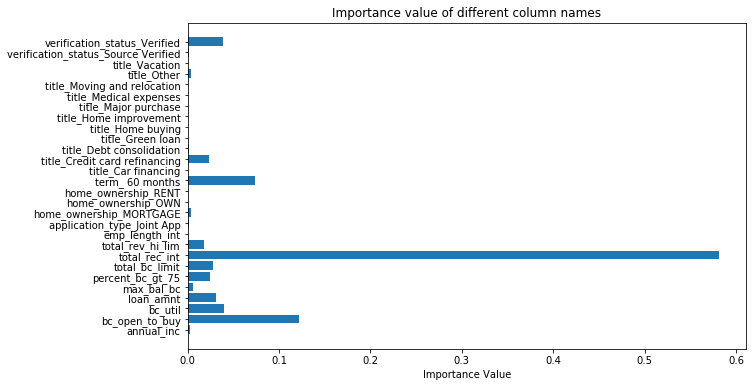

In [17]:
y = rfModel.featureImportances.toArray()
print('**Answer: The importance value of the model are:')
display(rfModel.featureImportances)

print('**Answer: According to the graph, the most important feature in the trained RandomForestClassifier is: total rec int, the interest revceived to date, having the importance value above 0.6.')

x = feature_cols

plt.figure(num = 1,figsize=(10,6))
plt.barh(range(len(x)),y)
plt.xlabel('Importance Value')
plt.title('Importance value of different column names')

plt.yticks(range(len(x)), x)

plt.show()

14) Perform predictions on both training dataframe and testing dataframe. Display the first 10 prediction results from both dataframe. 

In [18]:
predictions_train = rfModel.transform(train_df)
predictions_test = rfModel.transform(test_df)

print('**First 10 prediction results from training dataframe are:/n')
display(predictions_train.toPandas()['prediction'].head(10))
print('**First 10 prediction results from testing dataframe are:/n')
display(predictions_test.toPandas()['prediction'].head(10))

**First 10 prediction results from training dataframe are:/n


0    1.0
1    1.0
2    2.0
3    2.0
4    1.0
5    1.0
6    2.0
7    2.0
8    2.0
9    1.0
Name: prediction, dtype: float64

**First 10 prediction results from testing dataframe are:/n


0    2.0
1    2.0
2    2.0
3    1.0
4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    3.0
Name: prediction, dtype: float64

15) Finally, we want to look at the evaluation metrics of our model training result in pyspark. In this case particularly, we will use the class package **MulticlassClassificationEvaluator** to calculate the overall accuracy, f1 score, precision and recall. You need to print out the weighted F1, accuracy, weightedPrecision and weightedRecall on the testing dataset in your output.

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf_f1 = MulticlassClassificationEvaluator(labelCol="labelRandomForest", predictionCol='prediction',metricName='f1').evaluate(predictions_test)
print('**F1-score on the testing dataset is: {0:.5}'.format(rf_f1))
rf_accuracy=MulticlassClassificationEvaluator(labelCol='labelRandomForest',predictionCol='prediction',metricName='accuracy').evaluate(predictions_test)
print('**Accuracy on the testing dataset is： {0:.5}'.format(rf_accuracy))
rf_weightedPrecision = MulticlassClassificationEvaluator(labelCol="labelRandomForest", predictionCol='prediction',metricName='weightedPrecision').evaluate(predictions_test)
print('**Weighted Precision on the testing dataset is: {0:.5}'.format(rf_weightedPrecision))
rf_weightedRecall = MulticlassClassificationEvaluator(labelCol="labelRandomForest", predictionCol='prediction',metricName='weightedRecall').evaluate(predictions_test)
print('**Weighted Precision on the testing dataset is: {0:.5}'.format(rf_weightedRecall))

**F1-score on the testing dataset is: 0.68661
**Accuracy on the testing dataset is： 0.67979
**Weighted Precision on the testing dataset is: 0.72156
**Weighted Precision on the testing dataset is: 0.67979


### Stop Spark

In [20]:
spark.stop()